# DeepDream

In [1]:
# Loading the pretrained Inception V3 model
from keras.applications import inception_v3
from keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# disable all training-specific operations
K.set_learning_phase(0)

model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [2]:
# Setting up the DeepDream configuration
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

In [3]:
# Defining the loss to be maximized
layer_dict = dict([(layer.name, layer) for layer in model.layers])

loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    # Avoid border artifacts by only involving non-border pixels in the loss
    loss = loss + coeff * K.sum(K.square(activation[:, 2:-2, 2:-2, :])) / scaling

In [4]:
# Gradient-ascent process
dream = model.input

grads = K.gradients(loss, dream)[0]

grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]

fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

In [5]:
# Auxiliary functions
import scipy
import imageio
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    imageio.imwrite(fname, pil_img)

def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    if K.image_data_format() == 'channel_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [9]:
# Running gradient ascent over different successive scales
import numpy as np

step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20

max_loss = 10.

base_image_path = 'test.jpg'

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    loss_detail = same_size_original - upscaled_shrunk_original_img

    img += loss_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_'+str(shape)+'.png')
save_img(img, fname='final_dream.png')

Processing image shape (298, 478)
...Loss value at 0 : 1.0789261
...Loss value at 1 : 1.5253742
...Loss value at 2 : 2.1284995
...Loss value at 3 : 2.7874827
...Loss value at 4 : 3.4552062
...Loss value at 5 : 4.115874
...Loss value at 6 : 4.7459407
...Loss value at 7 : 5.395684
...Loss value at 8 : 5.9871974
...Loss value at 9 : 6.5574155
...Loss value at 10 : 7.095729
...Loss value at 11 : 7.6565886
...Loss value at 12 : 8.223333
...Loss value at 13 : 8.746052
...Loss value at 14 : 9.250641
...Loss value at 15 : 9.7560425
Processing image shape (418, 670)
...Loss value at 0 : 2.3246553
...Loss value at 1 : 3.578114
...Loss value at 2 : 4.6395535
...Loss value at 3 : 5.6079397
...Loss value at 4 : 6.5240207
...Loss value at 5 : 7.4088383
...Loss value at 6 : 8.289185
...Loss value at 7 : 9.114139
...Loss value at 8 :9.994997
Processing image shape (586, 938)
...Loss value at 0 : 2.4845092
...Loss value at 1 : 4.102541
...Loss value at 2 : 5.9522758
...Loss value at 3 : 8.379858


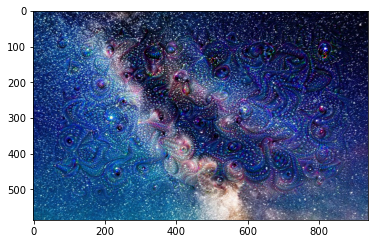

In [10]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()